In [2]:
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]'

In [90]:
from tqdm import tqdm
from collections import defaultdict
import math

In [3]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/opt/anaconda3/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


## Реализуем крестики-нолики

In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [527]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [59]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True)

-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
-------------
|   |   | o | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
-------------
| x |   | o | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
-------------
| x |   | o | 
-------------
|   | x |   | 
-------------
|   |   | o | 
-------------
-------------
| x |   | o | 
-------------
|   | x |   | 
-------------
| x |   | o | 
-------------
-------------
| x |   | o | 
-------------
| o | x |   | 
-------------
| x |   | o | 
-------------
-------------
| x | x | o | 
-------------
| o | x |   | 
-------------
| x |   | o | 
-------------
-------------
| x | x | o | 
-------------
| o | x |   | 
-------------
| x | o | o | 
-------------
-------------
| x | x | o | 
-------------
| o | x | x | 
-------------
| x | o | o | 
-------------


# Q-learning

## 3x3

In [75]:
def n_ones(x, max_pow):
    res = 0
    for i in range(max_pow):
        if x % 3 == 1:
            res += 1
        x = x // 3
    return res

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Крестики

In [76]:
def Q_learning_episode_x(env, Q, n_ceils, alpha=0.05, epsilon=0.0, gamma=0.9, rng=None):
    env.reset()
    s = int(env.getHash(), 3)
    if Q[s] is None:
        Q[s] = np.array([np.random.random() for _ in range(n_ones(s, n_ceils))])
    if np.random.rand() > epsilon:
        a_id = np.argmax(Q[s])
    else:
        a_id = np.random.randint(len(Q[s]))
    a = env.getEmptySpaces()[a_id]
    
    for i in range(1000):
        _, reward, done, _ = env.step(a)
        if not done:
            _, reward, done, _ = env.step(rng.choice(env.getEmptySpaces()))
        
        s_prime = int(env.getHash(), 3)
        if Q[s_prime] is None:
            Q[s_prime] = np.array([np.random.random() for _ in range(n_ones(s_prime, n_ceils))])
        max_sprime = np.max( Q[s_prime] ) if len(Q[s_prime]) > 0 else env.getWinner()
        Q[s][a_id] = Q[s][a_id] + alpha * (reward + gamma * max_sprime - Q[s][a_id])
        if done:
            break
        empty_spaces = env.getEmptySpaces()
        if np.random.rand() > epsilon:
            a_id = np.argmax(Q[s_prime])
        else:
            a_id = np.random.randint(len(Q[s_prime]))
        s, a = s_prime, empty_spaces[a_id]
    return env.getWinner()

In [66]:
n_rows, n_cols = 3, 3
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=3)
n_ceils = n_rows * n_cols
total_episodes = 100000
gamma = 0.9

rewards = np.zeros(total_episodes, dtype=int)

Q = [None for _ in range(3 ** n_ceils)]
epsilon = 0.1
rng = np.random.default_rng()

for n in tqdm(range(total_episodes)):
    if np.sqrt(n / 100) % 1 == 0:
        epsilon = epsilon / 2
    rewards[n] = Q_learning_episode_x(env, Q, n_ceils=n_ceils, alpha=0.1, epsilon=epsilon, gamma=gamma, rng=rng)

100%|██████████| 100000/100000 [00:41<00:00, 2392.89it/s]


Мы стремимся в 1к (потому что это усреднее по бачам размера 1к)

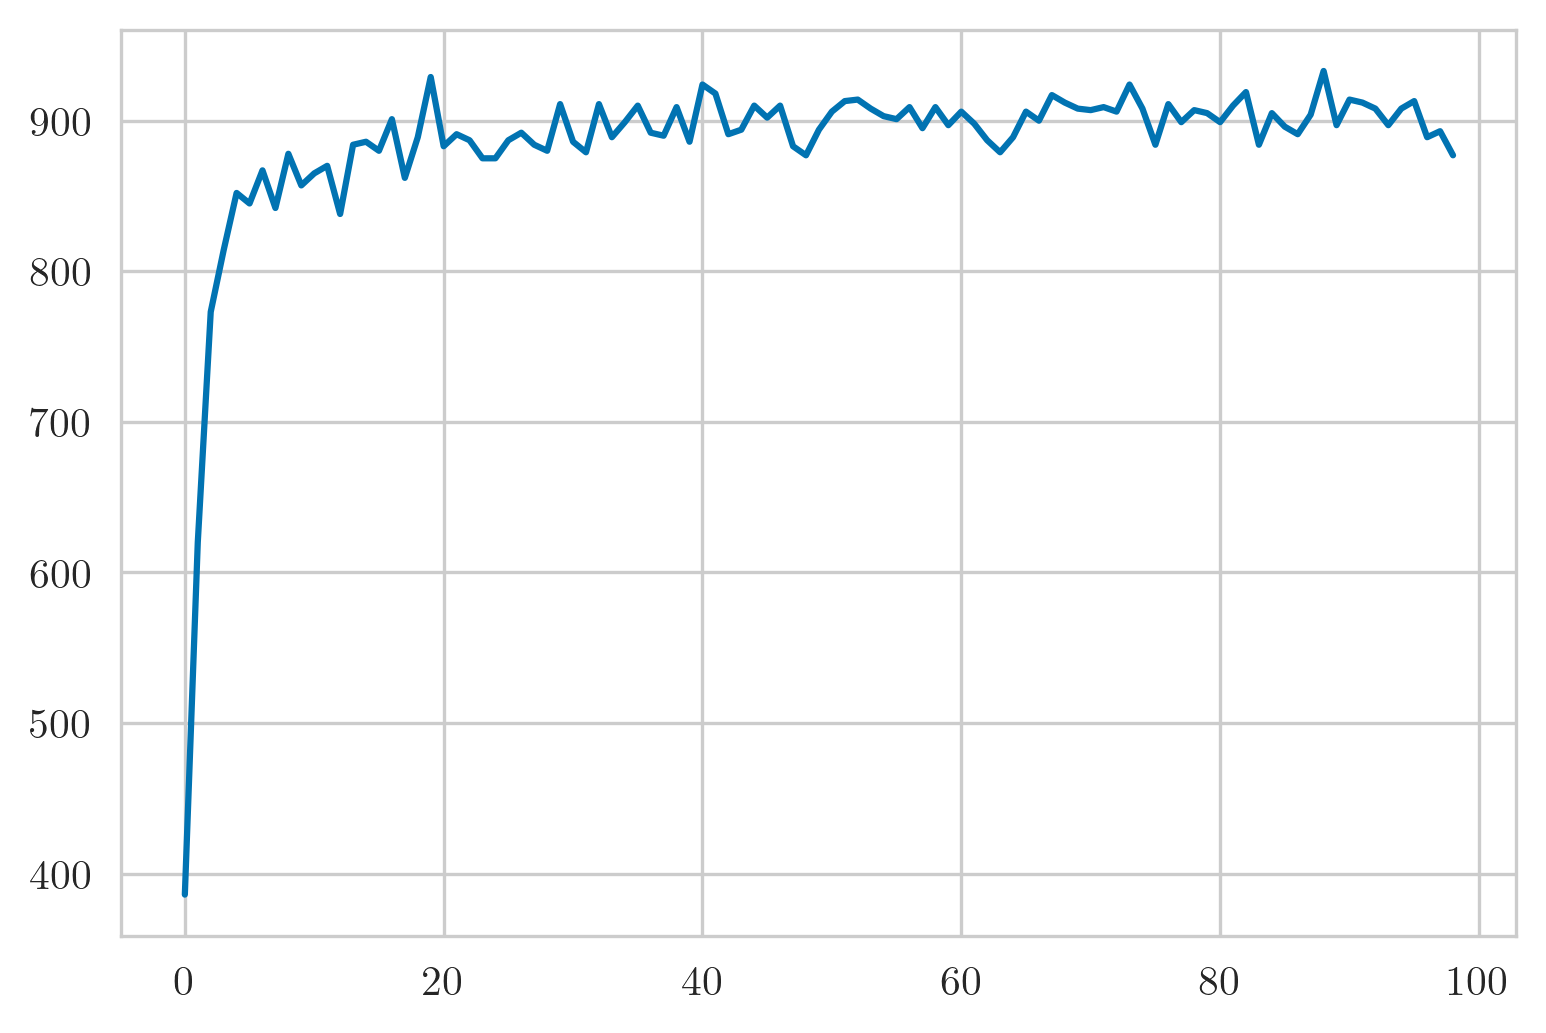

In [67]:
plt.plot([sum(rewards[(i * 1000): ((i + 1) * 1000)]) for i in range(99)])

### Нолики

In [87]:
def Q_learning_episode_o(env, Q, n_ceils, alpha=0.05, epsilon=0.0, gamma=0.9, rng=None):
    env.reset()
    env.step(rng.choice(env.getEmptySpaces()))
    s = int(env.getHash(), 3)
    if Q[s] is None:
        Q[s] = np.array([np.random.random() for _ in range(n_ones(s, n_ceils))])
    if np.random.rand() > epsilon:
        a_id = np.argmax(Q[s])
    else:
        a_id = np.random.randint(len(Q[s]))
    a = env.getEmptySpaces()[a_id]
    
    for i in range(1000):
        _, reward, done, _ = env.step(a)
        if not done:
            _, reward, done, _ = env.step(rng.choice(env.getEmptySpaces()))
        
        s_prime = int(env.getHash(), 3)
        if Q[s_prime] is None:
            Q[s_prime] = np.array([np.random.random() for _ in range(n_ones(s_prime, n_ceils))])
        max_sprime = np.max( Q[s_prime] ) if len(Q[s_prime]) > 0 else -env.getWinner()
        Q[s][a_id] = Q[s][a_id] + alpha * (-reward + gamma * max_sprime - Q[s][a_id])
        if done:
            break
        empty_spaces = env.getEmptySpaces()
        if np.random.rand() > epsilon:
            a_id = np.argmax(Q[s_prime])
        else:
            a_id = np.random.randint(len(Q[s_prime]))
        s, a = s_prime, empty_spaces[a_id]
    return -env.getWinner()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
n_rows, n_cols = 3, 3
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=3)
n_ceils = n_rows * n_cols
total_episodes = 100000
gamma = 0.9

rewards = np.zeros(total_episodes, dtype=int)

Q = [None for _ in range(3 ** n_ceils)]
epsilon = 0.1
rng = np.random.default_rng()

for n in tqdm(range(total_episodes)):
    if np.sqrt(n / 100) % 1 == 0:
        epsilon = epsilon / 2
    rewards[n] = Q_learning_episode_o(env, Q, n_ceils=n_ceils, alpha=0.1, epsilon=epsilon, gamma=gamma, rng=rng)

100%|██████████| 100000/100000 [00:51<00:00, 1925.05it/s]


Мы стремимся в 1к (потому что это усреднее по бачам размера 1к)

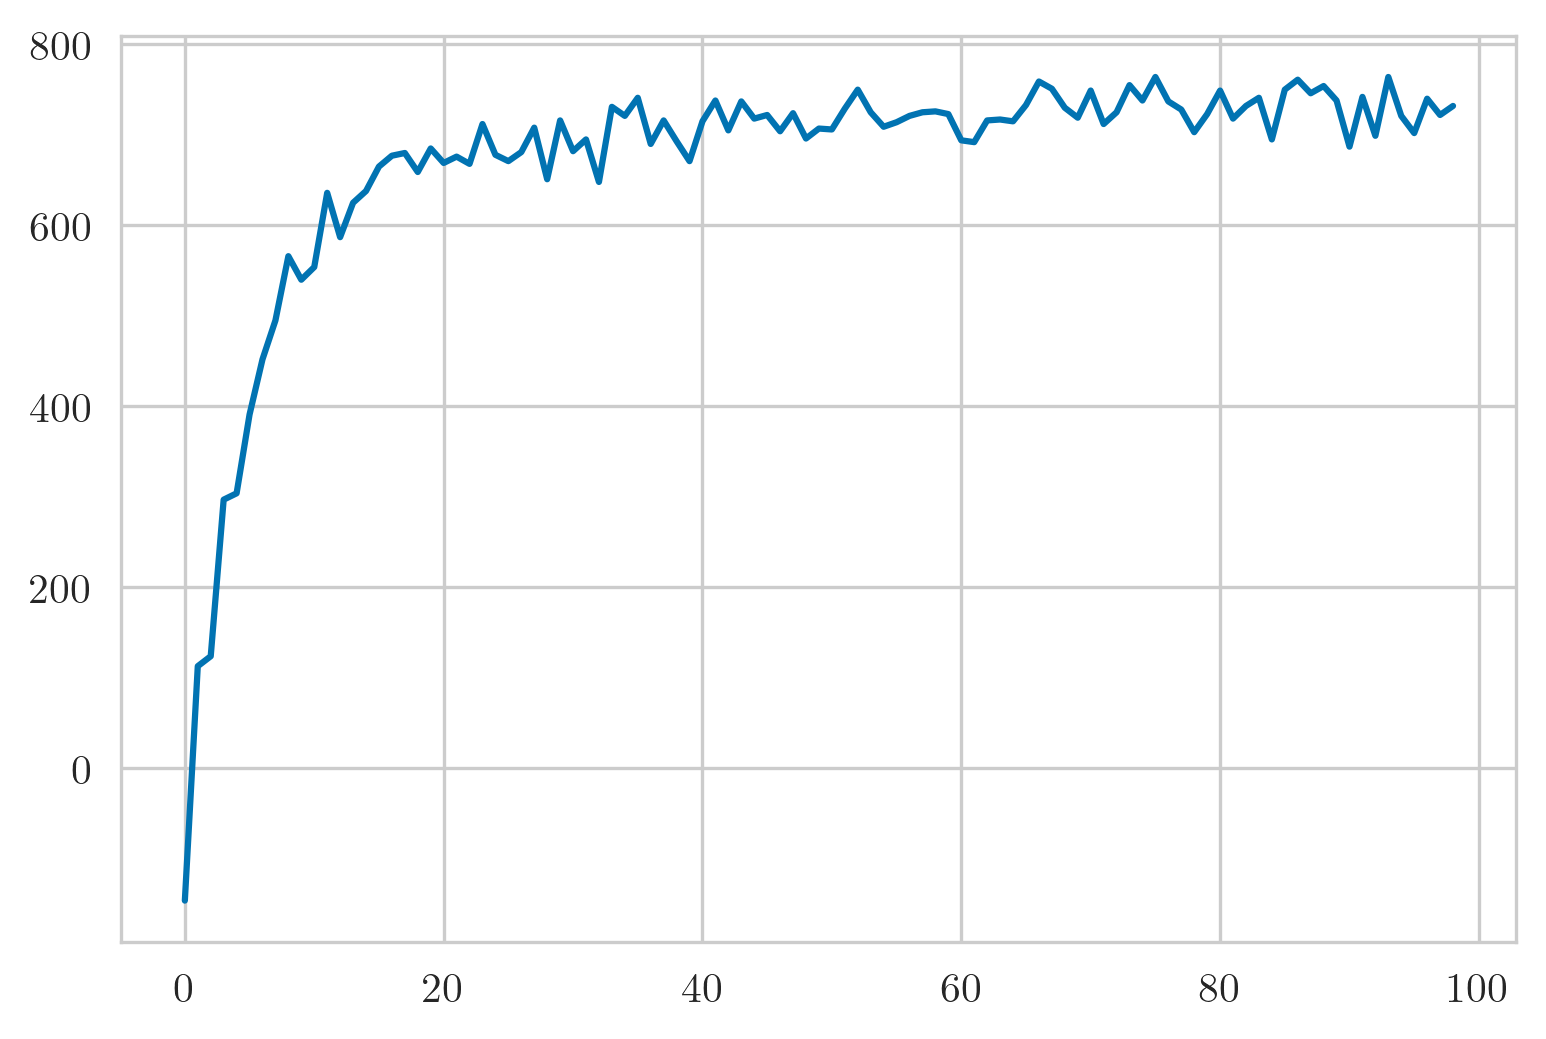

In [89]:
plt.plot([sum(rewards[(i * 1000): ((i + 1) * 1000)]) for i in range(99)])

## 4x4

In [73]:
n_rows, n_cols = 4, 4
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=4)
n_ceils = n_rows * n_cols

total_episodes = 400000
gamma = 0.9

rewards = np.zeros(total_episodes, dtype=int)

Q = [None for _ in range(3 ** n_ceils)]
epsilon = 0.1
rng = np.random.default_rng()

for n in tqdm(range(total_episodes)):
#     if np.sqrt(n / 100) % 1 == 0:
#         epsilon = epsilon / 2
    rewards[n] = Q_learning_episode_x(env, Q, n_ceils=n_ceils, alpha=0.1, epsilon=epsilon, gamma=gamma, rng=rng)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 400000/400000 [08:39<00:00, 769.47it/s]


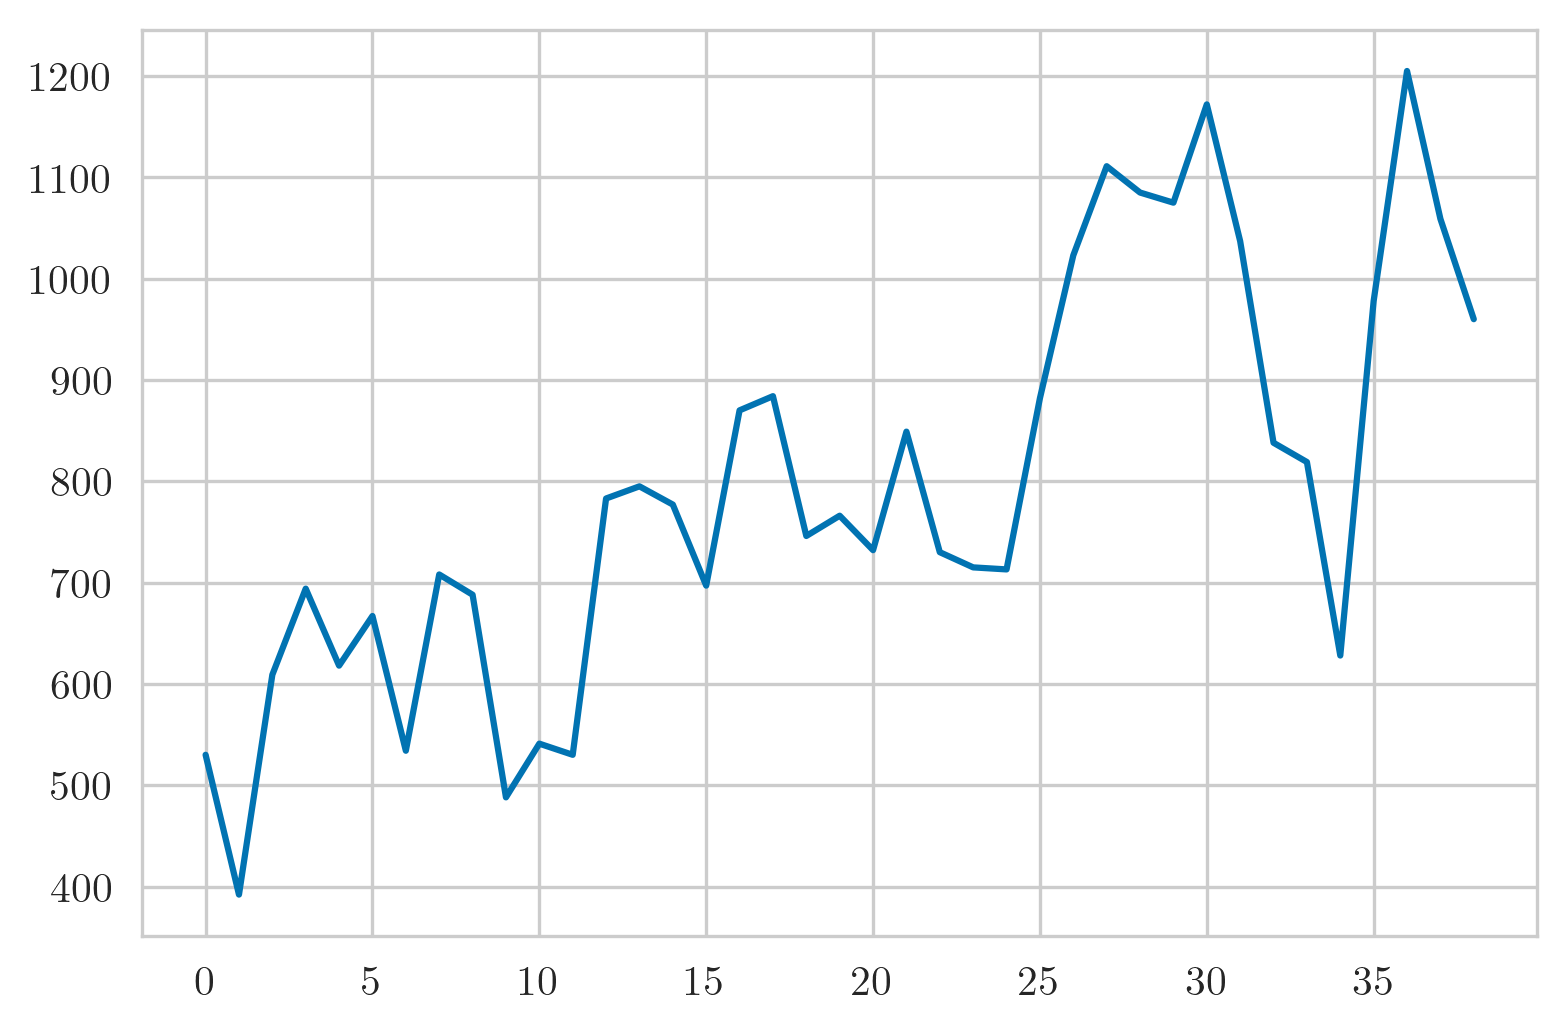

In [74]:
plt.plot([sum(rewards[(i * 10000): ((i + 1) * 10000)]) for i in range(39)])

Ползем вверх, но epsilon decay не смог подобрать

# MCTS

Я решил написать новый env, потому что не удобно ходить по старой так как хочу просто держать состояние, менять его и искать те которые могу сделать 

### 3x3

In [221]:
WIN_COMBOS = (
    [(i, i + 1, i + 2) for i in range(0, 9, 3)] + [(i, i + 3, i + 6) for i in range(3)] + [(0, 4, 8), (2, 4, 6)]
)

class myEnv_3:
    def __init__(self, state, turn, winner, terminal):
        self.state = state
        self.turn = turn
        self.winner = winner 
        self.terminal = terminal
        
    def next_states(self):
        if self.terminal: 
            return set()
        
        return {
            self.step(i) for i, pos in enumerate(self.state) if pos is None
        }

    def next_random_state(self):
        if self.terminal:
            return None  
        empty_spots = [i for i, pos in enumerate(self.state) if pos is None]
        return self.step(np.random.choice(empty_spots))
    
    def reward(self):
        if not self.terminal:
            return None
        if self.winner is self.turn:
            return None
        if self.turn is (not self.winner):
            return -1
        if self.winner is None:
            return 0
        return None
    
    def step(self, index):
        state = self.state[:index] + (self.turn,) + self.state[index + 1 :]
        turn = not self.turn
        winner = self._find_winner(state)
        is_terminal = (winner is not None) or not any(v is None for v in state)
        return myEnv_3(state, turn, winner, is_terminal)
    
    def show(self):
        f = lambda v: ("X" if v is True else ("O" if v is False else " "))
        rows = [
            [f(self.state[3 * row + col]) for col in range(3)] for row in range(3)
        ]
        return (
            "\n  1 2 3\n"
            + "\n".join(str(i + 1) + " " + " ".join(row) for i, row in enumerate(rows))
            + "\n"
        )
    
    
    def _find_winner(self, state):
        for i1, i2, i3 in WIN_COMBOS:
            v1, v2, v3 = state[i1], state[i2], state[i3]
            if False is v1 is v2 is v3:
                return False
            if True is v1 is v2 is v3:
                return True
        return None
    
    @staticmethod
    def new():
        return myEnv_3(state=(None,) * 9, turn=True, winner=None, terminal=False)

In [222]:
class MCTS:
    def __init__(self, c=1):
        self.Q = defaultdict(int)
        self.N = defaultdict(int)
        self.children = dict()
        self.c = c

    def choose(self, node):
        if node not in self.children:
            return node.next_random_state()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")
            return self.Q[n] / self.N[n]

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)

    def _expand(self, node):
        if node in self.children:
            return
        self.children[node] = node.next_states()

    def _simulate(self, node):
        invert_reward = True
        while True:
            if node.terminal:
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.next_random_state()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = - reward

    def _uct_select(self, node):
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = np.log(self.N[node])

        def uct(n):
            return self.Q[n] / self.N[n] + self.c * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)

### Нолики

In [223]:
def run_exp_3_o():
    tree = MCTS()
    env = myEnv_3.new()
    while True:
        env = env.next_random_state()
        if env.terminal:
            return env._find_winner(env.state)
        for _ in range(200):
            tree.do_rollout(env)
        env = tree.choose(env)
        if env.terminal:
            return env._find_winner(env.state)

    return env._find_winner(env.state)

N_IT = 1000

res = 0
for i in tqdm(range(N_IT)):
    win = run_exp_3_o()
    if win is None:
        continue
    if win:
        res += -1
    else:
        res += 1
    
print(res)

100%|██████████| 1000/1000 [00:41<00:00, 24.05it/s]

854


854 из 1000 выиграно

### 4x4

In [225]:
WIN_COMBOS = (
    [(i, i + 1, i + 2, i + 3) for i in range(0, 12, 4)] + \
    [(i, i + 4, i + 8, i + 12) for i in range(4)] + \
    [(0, 5, 10, 15), (3, 6, 9, 12)]
)

class myEnv_4:
    def __init__(self, state, turn, winner, terminal):
        self.state = state
        self.turn = turn
        self.winner = winner 
        self.terminal = terminal
        
    def next_states(self):
        if self.terminal: 
            return set()
        
        return {
            self.step(i) for i, pos in enumerate(self.state) if pos is None
        }

    def next_random_state(self):
        if self.terminal:
            return None  
        empty_spots = [i for i, pos in enumerate(self.state) if pos is None]
        return self.step(np.random.choice(empty_spots))
    
    def reward(self):
        if not self.terminal:
            return None
        if self.winner is self.turn:
            return None
        if self.turn is (not self.winner):
            return -1
        if self.winner is None:
            return 0
        return None
    
    def step(self, index):
        state = self.state[:index] + (self.turn,) + self.state[index + 1 :]
        turn = not self.turn
        winner = self._find_winner(state)
        is_terminal = (winner is not None) or not any(v is None for v in state)
        return myEnv_4(state, turn, winner, is_terminal)
    
    def show(self):
        f = lambda v: ("X" if v is True else ("O" if v is False else " "))
        rows = [
            [f(self.state[4 * row + col]) for col in range(4)] for row in range(4)
        ]
        return (
            "\n  1 2 3 4\n"
            + "\n".join(str(i + 1) + " " + " ".join(row) for i, row in enumerate(rows))
            + "\n"
        )
    
    
    def _find_winner(self, state):
        for i1, i2, i3, i4 in WIN_COMBOS:
            v1, v2, v3, v4 = state[i1], state[i2], state[i3], state[i4]
            if False is v1 is v2 is v3 is v4:
                return False
            if True is v1 is v2 is v3 is v4:
                return True
        return None
    
    @staticmethod
    def new():
        return myEnv_4(state=(None,) * 16, turn=True, winner=None, terminal=False)

In [226]:
def run_exp_4():
    tree = MCTS()
    env = myEnv_4.new()
    while True:
        for _ in range(200):
            tree.do_rollout(env)
        env = tree.choose(env)
        if env.terminal:
            return env._find_winner(env.state)
        env = env.next_random_state()
        if env.terminal:
            return env._find_winner(env.state)

    return env._find_winner(env.state)

N_IT = 1000

res = 0
for i in tqdm(range(N_IT)):
    win = run_exp_4()
    if win is None:
        continue
    if win:
        res += 1
    else:
        res += -1
    
print(res)

100%|██████████| 1000/1000 [04:10<00:00,  3.99it/s]

901


901 из 1000 выиграно

Из хорошего он сходится для 4х4 и можно против него играть. Качество судя по 3х3 даже лучше чем в 1ом (с DQN сравню, если успею ее завести) + если она играет сама против себя всегда старается свести в ничью, что тоже выглядит красиво

# DQN

In [356]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple, deque
from torch.autograd import Variable


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [584]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [611]:
class Network(nn.Module):
    def __init__(self, layer_size=256):
        nn.Module.__init__(self)
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=5, stride=1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2592, 256),
            nn.ReLU(),
            nn.Linear(256, 9)
        )

    def forward(self, x):
        return self.net(x)

In [654]:
class DQN(nn.Module):

    def __init__(self, env):
        nn.Module.__init__(self)
        self.env = env
        self.model = Network()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.rng = np.random.default_rng()
        self.gamma = 0.8
        self.batch_size = 64
        self.num_step = 0
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.rewards = []
        self.debug = {}
        
    def env_state(self):
        x = torch.FloatTensor([[int(x) for x in self.env.getHash()]])
        player1 = torch.zeros(x.size()).masked_scatter_((x == 0), torch.ones(x.size())).view(-1, 3, 3)
        empty = torch.zeros(x.size()).masked_scatter_((x == 1), torch.ones(x.size())).view(-1, 3, 3)
        player2 = torch.zeros(x.size()).masked_scatter_((x == 2), torch.ones(x.size())).view(-1, 3, 3)
        cnn_input = torch.stack((empty, player1, player2), dim=1)
        return cnn_input
        
    def select_greedy_action(self, state):
        return self.model(self.env_state()).max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            x = torch.FloatTensor([int(x) for x in self.env.getHash()])
            empty = torch.zeros(x.size()).masked_scatter_((x == 1), torch.ones(x.size())).view(-1)
            return torch.tensor([[np.random.choice(empty.nonzero().view(-1))]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        num_step = 0
        done = False
        while True:
            if render:
                self.env.printBoard()
                print(done)
            state_tensor = self.env_state()
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
                 
            pos = action.numpy()[0][0]
            x, y = pos // 3, pos % 3
            
            _, reward, done, _ = self.env.step((x, y))
            #done = self.env.getWinner() is not None
            if not done:
                _, reward, done, _ = self.env.step(self.rng.choice(self.env.getEmptySpaces()))  
            #done = self.env.getWinner() is not None
            next_state_tensor = self.env_state()

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()
            
            if done:
                print("\tepisode %d finished with reward %d" % (e, reward))
                self.rewards.append(reward)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        #print(loss.item())

In [655]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
dqn = DQN(env)

print("%s\tStarting training for 300 episodes..." % (datetime.now().time()))
for e in range(3000):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))

22:01:04.725848	Starting training for 300 episodes...
	episode 0 finished with reward 1
	episode 1 finished with reward 1
	episode 2 finished with reward -10
	episode 3 finished with reward 1
	episode 4 finished with reward -1
	episode 5 finished with reward -10
	episode 6 finished with reward -1
	episode 7 finished with reward 1
	episode 8 finished with reward -1
	episode 9 finished with reward -1
	episode 10 finished with reward -10
	episode 11 finished with reward -1
	episode 12 finished with reward 1
	episode 13 finished with reward -10
	episode 14 finished with reward -1
	episode 15 finished with reward -10
	episode 16 finished with reward -10
	episode 17 finished with reward 0
	episode 18 finished with reward -10
	episode 19 finished with reward -10
	episode 20 finished with reward 1
	episode 21 finished with reward 1
	episode 22 finished with reward -10
	episode 23 finished with reward 1
	episode 24 finished with reward -10
	episode 25 finished with reward 1
	episode 26 finished

	episode 223 finished with reward 1
	episode 224 finished with reward 1
	episode 225 finished with reward 1
	episode 226 finished with reward -10
	episode 227 finished with reward 1
	episode 228 finished with reward 1
	episode 229 finished with reward -10
	episode 230 finished with reward 1
	episode 231 finished with reward 1
	episode 232 finished with reward -1
	episode 233 finished with reward 1
	episode 234 finished with reward -1
	episode 235 finished with reward 1
	episode 236 finished with reward 0
	episode 237 finished with reward -10
	episode 238 finished with reward 1
	episode 239 finished with reward -1
	episode 240 finished with reward 1
	episode 241 finished with reward -1
	episode 242 finished with reward 1
	episode 243 finished with reward 1
	episode 244 finished with reward 1
	episode 245 finished with reward 1
	episode 246 finished with reward -1
	episode 247 finished with reward 1
	episode 248 finished with reward 1
	episode 249 finished with reward 1
	episode 250 fini

	episode 450 finished with reward 1
	episode 451 finished with reward 1
	episode 452 finished with reward 1
	episode 453 finished with reward -10
	episode 454 finished with reward 1
	episode 455 finished with reward 1
	episode 456 finished with reward 1
	episode 457 finished with reward 1
	episode 458 finished with reward 1
	episode 459 finished with reward 1
	episode 460 finished with reward 1
	episode 461 finished with reward 1
	episode 462 finished with reward 1
	episode 463 finished with reward 1
	episode 464 finished with reward 1
	episode 465 finished with reward 1
	episode 466 finished with reward 1
	episode 467 finished with reward 1
	episode 468 finished with reward -10
	episode 469 finished with reward 1
	episode 470 finished with reward 1
	episode 471 finished with reward 0
	episode 472 finished with reward 1
	episode 473 finished with reward 1
	episode 474 finished with reward 1
	episode 475 finished with reward 1
	episode 476 finished with reward 0
	episode 477 finished wi

	episode 679 finished with reward 1
	episode 680 finished with reward -1
	episode 681 finished with reward 1
	episode 682 finished with reward -1
	episode 683 finished with reward 1
	episode 684 finished with reward 1
	episode 685 finished with reward 1
	episode 686 finished with reward 1
	episode 687 finished with reward 1
	episode 688 finished with reward 1
	episode 689 finished with reward 1
	episode 690 finished with reward 1
	episode 691 finished with reward 1
	episode 692 finished with reward 1
	episode 693 finished with reward 1
	episode 694 finished with reward -1
	episode 695 finished with reward 1
	episode 696 finished with reward 1
	episode 697 finished with reward -1
	episode 698 finished with reward -10
	episode 699 finished with reward 0
	episode 700 finished with reward 1
	episode 701 finished with reward 1
	episode 702 finished with reward 1
	episode 703 finished with reward 1
	episode 704 finished with reward 1
	episode 705 finished with reward 1
	episode 706 finished 

	episode 905 finished with reward -1
	episode 906 finished with reward 1
	episode 907 finished with reward 1
	episode 908 finished with reward 1
	episode 909 finished with reward 1
	episode 910 finished with reward -1
	episode 911 finished with reward 1
	episode 912 finished with reward 1
	episode 913 finished with reward 1
	episode 914 finished with reward 1
	episode 915 finished with reward -10
	episode 916 finished with reward 1
	episode 917 finished with reward 1
	episode 918 finished with reward 1
	episode 919 finished with reward 1
	episode 920 finished with reward 1
	episode 921 finished with reward 1
	episode 922 finished with reward 1
	episode 923 finished with reward 1
	episode 924 finished with reward 1
	episode 925 finished with reward 1
	episode 926 finished with reward 1
	episode 927 finished with reward 1
	episode 928 finished with reward 1
	episode 929 finished with reward 1
	episode 930 finished with reward 1
	episode 931 finished with reward 1
	episode 932 finished wi

	episode 1130 finished with reward 1
	episode 1131 finished with reward 1
	episode 1132 finished with reward 1
	episode 1133 finished with reward 1
	episode 1134 finished with reward 1
	episode 1135 finished with reward 1
	episode 1136 finished with reward 1
	episode 1137 finished with reward 1
	episode 1138 finished with reward 1
	episode 1139 finished with reward 1
	episode 1140 finished with reward 1
	episode 1141 finished with reward 1
	episode 1142 finished with reward 1
	episode 1143 finished with reward 1
	episode 1144 finished with reward 1
	episode 1145 finished with reward 1
	episode 1146 finished with reward 1
	episode 1147 finished with reward 1
	episode 1148 finished with reward 1
	episode 1149 finished with reward 1
	episode 1150 finished with reward 1
	episode 1151 finished with reward 1
	episode 1152 finished with reward 1
	episode 1153 finished with reward 1
	episode 1154 finished with reward -1
	episode 1155 finished with reward 1
	episode 1156 finished with reward 1


	episode 1353 finished with reward 1
	episode 1354 finished with reward 1
	episode 1355 finished with reward 1
	episode 1356 finished with reward 1
	episode 1357 finished with reward 1
	episode 1358 finished with reward 1
	episode 1359 finished with reward 1
	episode 1360 finished with reward 1
	episode 1361 finished with reward 1
	episode 1362 finished with reward 1
	episode 1363 finished with reward 1
	episode 1364 finished with reward 1
	episode 1365 finished with reward 1
	episode 1366 finished with reward 1
	episode 1367 finished with reward 1
	episode 1368 finished with reward 1
	episode 1369 finished with reward -1
	episode 1370 finished with reward 1
	episode 1371 finished with reward 1
	episode 1372 finished with reward 1
	episode 1373 finished with reward 1
	episode 1374 finished with reward 1
	episode 1375 finished with reward 1
	episode 1376 finished with reward 1
	episode 1377 finished with reward 1
	episode 1378 finished with reward 1
	episode 1379 finished with reward 1


	episode 1575 finished with reward 1
	episode 1576 finished with reward 1
	episode 1577 finished with reward 1
	episode 1578 finished with reward 1
	episode 1579 finished with reward 1
	episode 1580 finished with reward 1
	episode 1581 finished with reward 1
	episode 1582 finished with reward 1
	episode 1583 finished with reward 1
	episode 1584 finished with reward 1
	episode 1585 finished with reward 1
	episode 1586 finished with reward 1
	episode 1587 finished with reward 1
	episode 1588 finished with reward 1
	episode 1589 finished with reward 1
	episode 1590 finished with reward 1
	episode 1591 finished with reward 1
	episode 1592 finished with reward 1
	episode 1593 finished with reward 1
	episode 1594 finished with reward 1
	episode 1595 finished with reward 1
	episode 1596 finished with reward 1
	episode 1597 finished with reward -10
	episode 1598 finished with reward 1
	episode 1599 finished with reward 1
	episode 1600 finished with reward 1
	episode 1601 finished with reward 1

	episode 1797 finished with reward 1
	episode 1798 finished with reward 1
	episode 1799 finished with reward 1
	episode 1800 finished with reward 1
	episode 1801 finished with reward 1
	episode 1802 finished with reward 1
	episode 1803 finished with reward 1
	episode 1804 finished with reward 1
	episode 1805 finished with reward 1
	episode 1806 finished with reward -1
	episode 1807 finished with reward 0
	episode 1808 finished with reward 1
	episode 1809 finished with reward 1
	episode 1810 finished with reward 1
	episode 1811 finished with reward 1
	episode 1812 finished with reward 1
	episode 1813 finished with reward 1
	episode 1814 finished with reward 1
	episode 1815 finished with reward 1
	episode 1816 finished with reward 1
	episode 1817 finished with reward 1
	episode 1818 finished with reward 1
	episode 1819 finished with reward 1
	episode 1820 finished with reward 1
	episode 1821 finished with reward 1
	episode 1822 finished with reward 1
	episode 1823 finished with reward 1


	episode 2019 finished with reward 1
	episode 2020 finished with reward 1
	episode 2021 finished with reward 1
	episode 2022 finished with reward 1
	episode 2023 finished with reward 1
	episode 2024 finished with reward 1
	episode 2025 finished with reward 1
	episode 2026 finished with reward 1
	episode 2027 finished with reward 1
	episode 2028 finished with reward -1
	episode 2029 finished with reward 1
	episode 2030 finished with reward 0
	episode 2031 finished with reward 1
	episode 2032 finished with reward 1
	episode 2033 finished with reward 1
	episode 2034 finished with reward 1
	episode 2035 finished with reward 1
	episode 2036 finished with reward 1
	episode 2037 finished with reward 1
	episode 2038 finished with reward 1
	episode 2039 finished with reward 1
	episode 2040 finished with reward 1
	episode 2041 finished with reward 1
	episode 2042 finished with reward 1
	episode 2043 finished with reward 1
	episode 2044 finished with reward 1
	episode 2045 finished with reward 1


	episode 2240 finished with reward 1
	episode 2241 finished with reward 1
	episode 2242 finished with reward 1
	episode 2243 finished with reward 1
	episode 2244 finished with reward 1
	episode 2245 finished with reward 1
	episode 2246 finished with reward -1
	episode 2247 finished with reward 1
	episode 2248 finished with reward 1
	episode 2249 finished with reward 1
	episode 2250 finished with reward 1
	episode 2251 finished with reward 1
	episode 2252 finished with reward 1
	episode 2253 finished with reward 1
	episode 2254 finished with reward 1
	episode 2255 finished with reward 1
	episode 2256 finished with reward 1
	episode 2257 finished with reward 1
	episode 2258 finished with reward 1
	episode 2259 finished with reward 1
	episode 2260 finished with reward 1
	episode 2261 finished with reward 1
	episode 2262 finished with reward 1
	episode 2263 finished with reward 1
	episode 2264 finished with reward 1
	episode 2265 finished with reward 1
	episode 2266 finished with reward 1


	episode 2462 finished with reward 1
	episode 2463 finished with reward 1
	episode 2464 finished with reward 1
	episode 2465 finished with reward -1
	episode 2466 finished with reward 1
	episode 2467 finished with reward 1
	episode 2468 finished with reward 1
	episode 2469 finished with reward 1
	episode 2470 finished with reward 1
	episode 2471 finished with reward 1
	episode 2472 finished with reward 1
	episode 2473 finished with reward -1
	episode 2474 finished with reward 1
	episode 2475 finished with reward 1
	episode 2476 finished with reward 1
	episode 2477 finished with reward 1
	episode 2478 finished with reward 1
	episode 2479 finished with reward 1
	episode 2480 finished with reward 1
	episode 2481 finished with reward 1
	episode 2482 finished with reward 1
	episode 2483 finished with reward 1
	episode 2484 finished with reward 1
	episode 2485 finished with reward 1
	episode 2486 finished with reward 1
	episode 2487 finished with reward 1
	episode 2488 finished with reward -

	episode 2684 finished with reward 1
	episode 2685 finished with reward 1
	episode 2686 finished with reward 1
	episode 2687 finished with reward 1
	episode 2688 finished with reward 1
	episode 2689 finished with reward 1
	episode 2690 finished with reward 1
	episode 2691 finished with reward 1
	episode 2692 finished with reward 1
	episode 2693 finished with reward 1
	episode 2694 finished with reward 1
	episode 2695 finished with reward 1
	episode 2696 finished with reward 1
	episode 2697 finished with reward 1
	episode 2698 finished with reward 1
	episode 2699 finished with reward 1
	episode 2700 finished with reward 1
	episode 2701 finished with reward 1
	episode 2702 finished with reward 1
	episode 2703 finished with reward 1
	episode 2704 finished with reward 1
	episode 2705 finished with reward 1
	episode 2706 finished with reward 1
	episode 2707 finished with reward 1
	episode 2708 finished with reward 1
	episode 2709 finished with reward 1
	episode 2710 finished with reward 1
	

	episode 2906 finished with reward 1
	episode 2907 finished with reward 1
	episode 2908 finished with reward 1
	episode 2909 finished with reward 1
	episode 2910 finished with reward 1
	episode 2911 finished with reward 1
	episode 2912 finished with reward 1
	episode 2913 finished with reward 1
	episode 2914 finished with reward 1
	episode 2915 finished with reward 1
	episode 2916 finished with reward 1
	episode 2917 finished with reward 1
	episode 2918 finished with reward 1
	episode 2919 finished with reward 1
	episode 2920 finished with reward 1
	episode 2921 finished with reward 1
	episode 2922 finished with reward 1
	episode 2923 finished with reward 1
	episode 2924 finished with reward 1
	episode 2925 finished with reward 1
	episode 2926 finished with reward 1
	episode 2927 finished with reward 1
	episode 2928 finished with reward 1
	episode 2929 finished with reward 1
	episode 2930 finished with reward 1
	episode 2931 finished with reward 1
	episode 2932 finished with reward 1
	

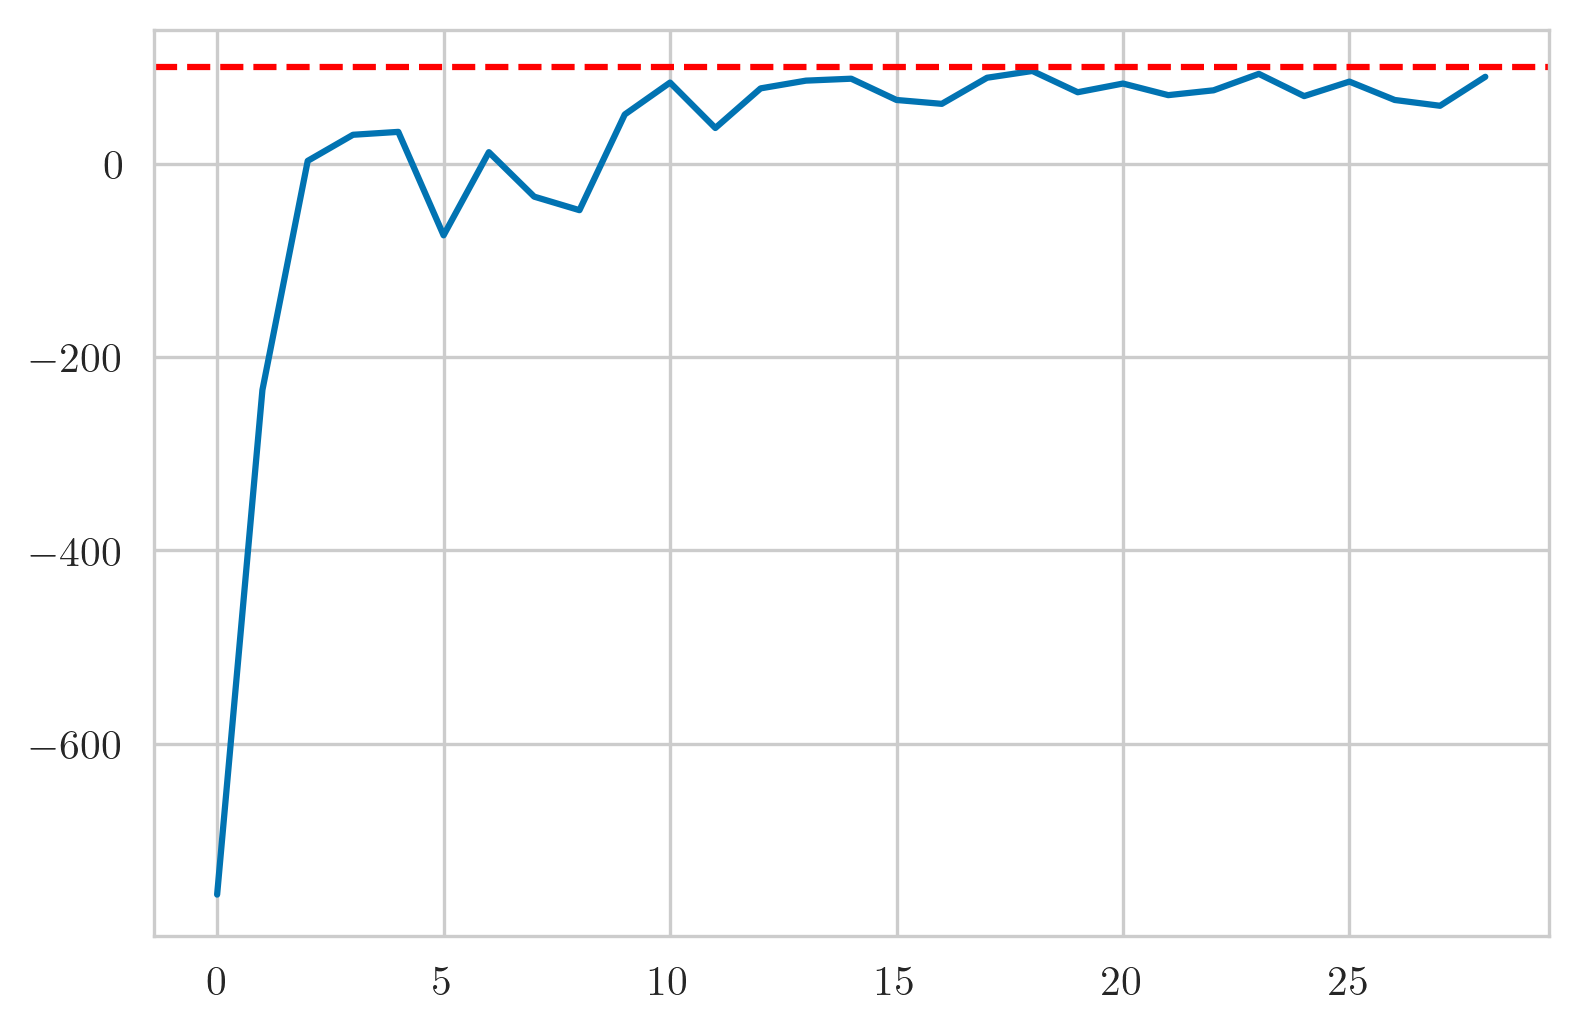

In [665]:
plt.plot([sum(dqn.rewards[(i * 100): ((i + 1) * 100)]) for i in range(29)])
plt.axhline(y=100, color='r', linestyle='--')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


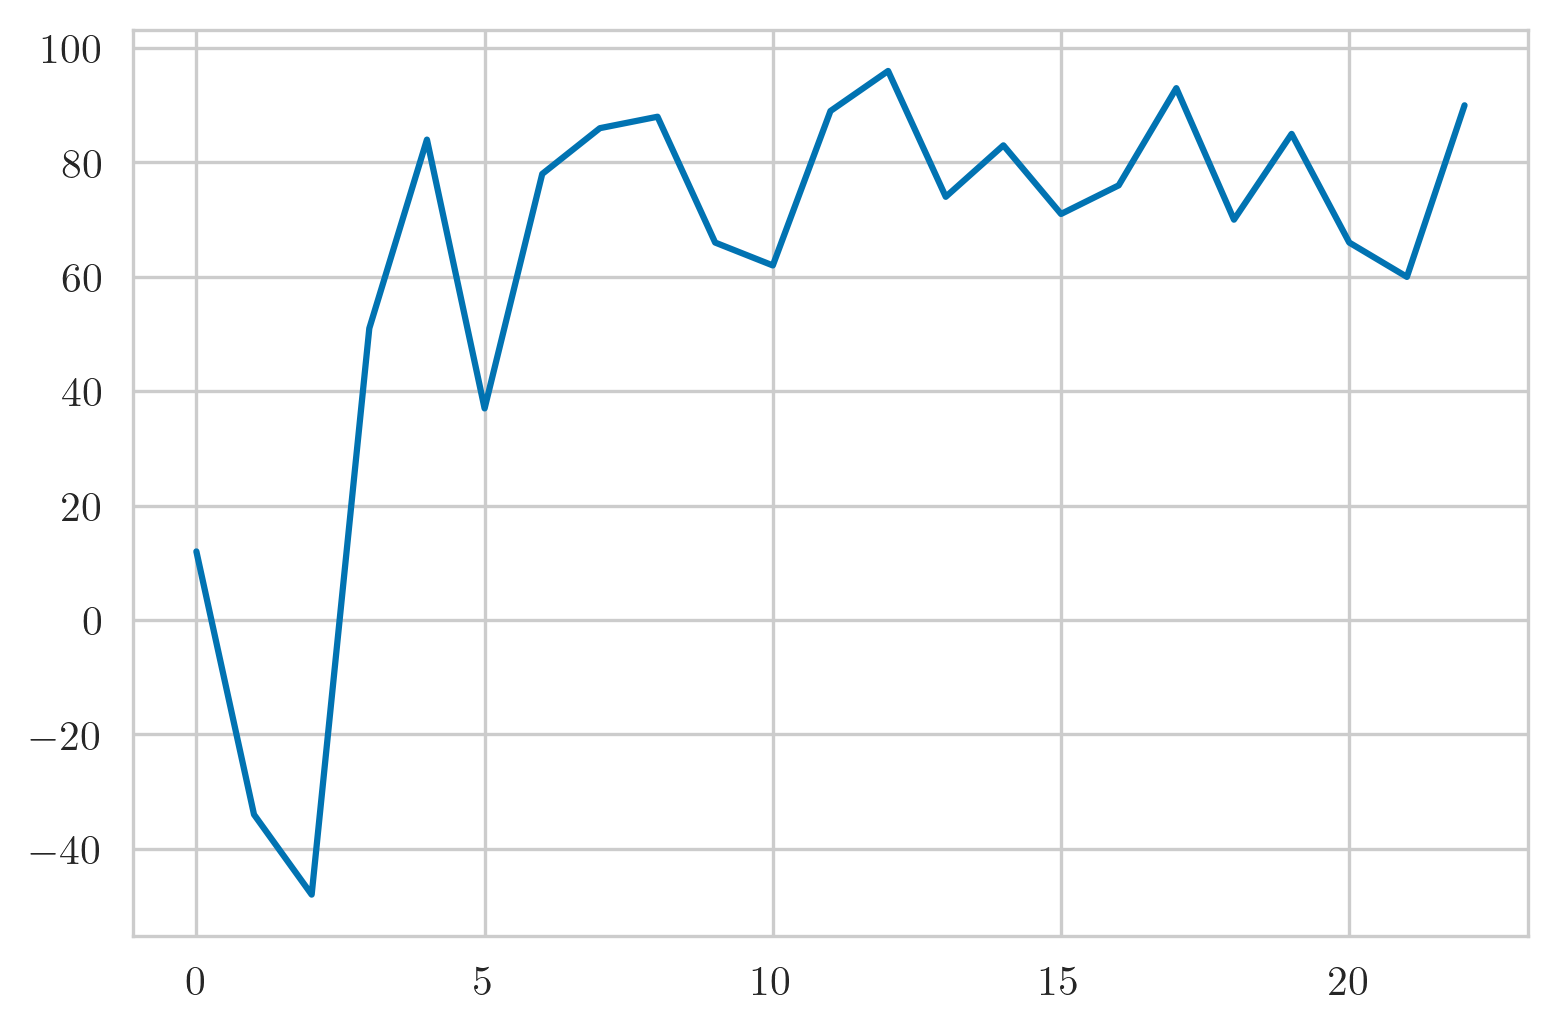

In [667]:
plt.plot([sum(dqn.rewards[(i * 100): ((i + 1) * 100)]) for i in range(6, 29)])

Если сравинвать DQN с MCTS, то MCTS лучше сходится (чаще выигрывает чем обученная DQN) 

### Double-DQN

In [670]:
class DDQN(nn.Module):

    def __init__(self, env):
        nn.Module.__init__(self)
        self.env = env
        self.model_a = Network()
        self.model_b = Network()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model_a.parameters(), 0.001)
        self.rng = np.random.default_rng()
        self.gamma = 0.8
        self.batch_size = 64
        self.num_step = 0
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.rewards = []
        self.debug = {}
        
    def env_state(self):
        x = torch.FloatTensor([[int(x) for x in self.env.getHash()]])
        player1 = torch.zeros(x.size()).masked_scatter_((x == 0), torch.ones(x.size())).view(-1, 3, 3)
        empty = torch.zeros(x.size()).masked_scatter_((x == 1), torch.ones(x.size())).view(-1, 3, 3)
        player2 = torch.zeros(x.size()).masked_scatter_((x == 2), torch.ones(x.size())).view(-1, 3, 3)
        cnn_input = torch.stack((empty, player1, player2), dim=1)
        return cnn_input
        
    def select_greedy_action(self, state):
        return self.model_a(self.env_state()).max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            x = torch.FloatTensor([int(x) for x in self.env.getHash()])
            empty = torch.zeros(x.size()).masked_scatter_((x == 1), torch.ones(x.size())).view(-1)
            return torch.tensor([[np.random.choice(empty.nonzero().view(-1))]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        num_step = 0
        done = False
        while True:
            if render:
                self.env.printBoard()
                print(done)
            state_tensor = self.env_state()
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
                 
            pos = action.numpy()[0][0]
            x, y = pos // 3, pos % 3
            
            _, reward, done, _ = self.env.step((x, y))
            #done = self.env.getWinner() is not None
            if not done:
                _, reward, done, _ = self.env.step(self.rng.choice(self.env.getEmptySpaces()))  
            #done = self.env.getWinner() is not None
            next_state_tensor = self.env_state()

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()
            
            if done:
                print("\tepisode %d finished with reward %d" % (e, reward))
                self.rewards.append(reward)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model_a(batch_state).gather(1, batch_action).reshape([self.batch_size])
        
        next_q_values = self.model_a(batch_next_state)
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model_b(batch_next_state).detach().gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        #print(loss.item())

In [671]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
dqn = DQN(env)

print("%s\tStarting training for 300 episodes..." % (datetime.now().time()))
for e in range(3000):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))

23:05:00.427604	Starting training for 300 episodes...
	episode 0 finished with reward 1
	episode 1 finished with reward 1
	episode 2 finished with reward 1
	episode 3 finished with reward 1
	episode 4 finished with reward 1
	episode 5 finished with reward 1
	episode 6 finished with reward -1
	episode 7 finished with reward -10
	episode 8 finished with reward -10
	episode 9 finished with reward 0
	episode 10 finished with reward -10
	episode 11 finished with reward -1
	episode 12 finished with reward -10
	episode 13 finished with reward -10
	episode 14 finished with reward 1
	episode 15 finished with reward -1
	episode 16 finished with reward -10
	episode 17 finished with reward 1
	episode 18 finished with reward -1
	episode 19 finished with reward -10
	episode 20 finished with reward -10
	episode 21 finished with reward -1
	episode 22 finished with reward -10
	episode 23 finished with reward 1
	episode 24 finished with reward -1
	episode 25 finished with reward 1
	episode 26 finished w

	episode 228 finished with reward 1
	episode 229 finished with reward 1
	episode 230 finished with reward 0
	episode 231 finished with reward 1
	episode 232 finished with reward -10
	episode 233 finished with reward -1
	episode 234 finished with reward 1
	episode 235 finished with reward -10
	episode 236 finished with reward 1
	episode 237 finished with reward 1
	episode 238 finished with reward -10
	episode 239 finished with reward -1
	episode 240 finished with reward -10
	episode 241 finished with reward -10
	episode 242 finished with reward 1
	episode 243 finished with reward -1
	episode 244 finished with reward 1
	episode 245 finished with reward 1
	episode 246 finished with reward 1
	episode 247 finished with reward -1
	episode 248 finished with reward 1
	episode 249 finished with reward 1
	episode 250 finished with reward -10
	episode 251 finished with reward -1
	episode 252 finished with reward 1
	episode 253 finished with reward 1
	episode 254 finished with reward 1
	episode 25

	episode 457 finished with reward 1
	episode 458 finished with reward 1
	episode 459 finished with reward 1
	episode 460 finished with reward 1
	episode 461 finished with reward 1
	episode 462 finished with reward 1
	episode 463 finished with reward -10
	episode 464 finished with reward 1
	episode 465 finished with reward 1
	episode 466 finished with reward 1
	episode 467 finished with reward 1
	episode 468 finished with reward 1
	episode 469 finished with reward 1
	episode 470 finished with reward 1
	episode 471 finished with reward -1
	episode 472 finished with reward 1
	episode 473 finished with reward 1
	episode 474 finished with reward 1
	episode 475 finished with reward 1
	episode 476 finished with reward 1
	episode 477 finished with reward 1
	episode 478 finished with reward 1
	episode 479 finished with reward 1
	episode 480 finished with reward 1
	episode 481 finished with reward 1
	episode 482 finished with reward 1
	episode 483 finished with reward -1
	episode 484 finished wi

	episode 685 finished with reward 1
	episode 686 finished with reward 1
	episode 687 finished with reward 1
	episode 688 finished with reward 1
	episode 689 finished with reward 1
	episode 690 finished with reward 1
	episode 691 finished with reward 1
	episode 692 finished with reward 1
	episode 693 finished with reward 1
	episode 694 finished with reward 1
	episode 695 finished with reward 1
	episode 696 finished with reward 1
	episode 697 finished with reward 1
	episode 698 finished with reward 1
	episode 699 finished with reward 1
	episode 700 finished with reward 1
	episode 701 finished with reward 1
	episode 702 finished with reward 1
	episode 703 finished with reward 1
	episode 704 finished with reward 1
	episode 705 finished with reward 1
	episode 706 finished with reward 1
	episode 707 finished with reward 1
	episode 708 finished with reward 1
	episode 709 finished with reward 1
	episode 710 finished with reward -1
	episode 711 finished with reward 1
	episode 712 finished with 

	episode 912 finished with reward 1
	episode 913 finished with reward 1
	episode 914 finished with reward 1
	episode 915 finished with reward 1
	episode 916 finished with reward 1
	episode 917 finished with reward 1
	episode 918 finished with reward -10
	episode 919 finished with reward -1
	episode 920 finished with reward 1
	episode 921 finished with reward 1
	episode 922 finished with reward 1
	episode 923 finished with reward 1
	episode 924 finished with reward 1
	episode 925 finished with reward 1
	episode 926 finished with reward 1
	episode 927 finished with reward 1
	episode 928 finished with reward 1
	episode 929 finished with reward -1
	episode 930 finished with reward 1
	episode 931 finished with reward 1
	episode 932 finished with reward 1
	episode 933 finished with reward 1
	episode 934 finished with reward 1
	episode 935 finished with reward 1
	episode 936 finished with reward 1
	episode 937 finished with reward 1
	episode 938 finished with reward -1
	episode 939 finished w

	episode 1136 finished with reward 1
	episode 1137 finished with reward 1
	episode 1138 finished with reward 1
	episode 1139 finished with reward 1
	episode 1140 finished with reward 1
	episode 1141 finished with reward 1
	episode 1142 finished with reward 1
	episode 1143 finished with reward 1
	episode 1144 finished with reward 1
	episode 1145 finished with reward 1
	episode 1146 finished with reward 1
	episode 1147 finished with reward 1
	episode 1148 finished with reward 1
	episode 1149 finished with reward 1
	episode 1150 finished with reward 1
	episode 1151 finished with reward 1
	episode 1152 finished with reward 1
	episode 1153 finished with reward 1
	episode 1154 finished with reward -1
	episode 1155 finished with reward 1
	episode 1156 finished with reward 1
	episode 1157 finished with reward 1
	episode 1158 finished with reward 1
	episode 1159 finished with reward 1
	episode 1160 finished with reward 1
	episode 1161 finished with reward 1
	episode 1162 finished with reward 1


	episode 1358 finished with reward 1
	episode 1359 finished with reward 1
	episode 1360 finished with reward 1
	episode 1361 finished with reward 0
	episode 1362 finished with reward 1
	episode 1363 finished with reward -1
	episode 1364 finished with reward 1
	episode 1365 finished with reward -1
	episode 1366 finished with reward 1
	episode 1367 finished with reward 1
	episode 1368 finished with reward 1
	episode 1369 finished with reward 1
	episode 1370 finished with reward 1
	episode 1371 finished with reward 1
	episode 1372 finished with reward 1
	episode 1373 finished with reward 1
	episode 1374 finished with reward 1
	episode 1375 finished with reward 1
	episode 1376 finished with reward 1
	episode 1377 finished with reward -10
	episode 1378 finished with reward 1
	episode 1379 finished with reward 1
	episode 1380 finished with reward 1
	episode 1381 finished with reward 1
	episode 1382 finished with reward 1
	episode 1383 finished with reward 1
	episode 1384 finished with reward

	episode 1580 finished with reward 1
	episode 1581 finished with reward -1
	episode 1582 finished with reward 1
	episode 1583 finished with reward 1
	episode 1584 finished with reward 1
	episode 1585 finished with reward -1
	episode 1586 finished with reward 1
	episode 1587 finished with reward 1
	episode 1588 finished with reward 1
	episode 1589 finished with reward 1
	episode 1590 finished with reward 1
	episode 1591 finished with reward 1
	episode 1592 finished with reward 1
	episode 1593 finished with reward -1
	episode 1594 finished with reward 1
	episode 1595 finished with reward 1
	episode 1596 finished with reward 1
	episode 1597 finished with reward 1
	episode 1598 finished with reward 1
	episode 1599 finished with reward 1
	episode 1600 finished with reward -1
	episode 1601 finished with reward 1
	episode 1602 finished with reward -1
	episode 1603 finished with reward 1
	episode 1604 finished with reward 1
	episode 1605 finished with reward 1
	episode 1606 finished with rewar

	episode 1803 finished with reward 1
	episode 1804 finished with reward 1
	episode 1805 finished with reward 1
	episode 1806 finished with reward 1
	episode 1807 finished with reward -10
	episode 1808 finished with reward 1
	episode 1809 finished with reward 1
	episode 1810 finished with reward 1
	episode 1811 finished with reward 1
	episode 1812 finished with reward 1
	episode 1813 finished with reward 1
	episode 1814 finished with reward -10
	episode 1815 finished with reward 1
	episode 1816 finished with reward -1
	episode 1817 finished with reward 1
	episode 1818 finished with reward 1
	episode 1819 finished with reward 1
	episode 1820 finished with reward 1
	episode 1821 finished with reward -10
	episode 1822 finished with reward 1
	episode 1823 finished with reward 1
	episode 1824 finished with reward 1
	episode 1825 finished with reward 1
	episode 1826 finished with reward 1
	episode 1827 finished with reward 1
	episode 1828 finished with reward 1
	episode 1829 finished with rew

	episode 2024 finished with reward 1
	episode 2025 finished with reward 1
	episode 2026 finished with reward 1
	episode 2027 finished with reward 1
	episode 2028 finished with reward 1
	episode 2029 finished with reward 1
	episode 2030 finished with reward 1
	episode 2031 finished with reward 1
	episode 2032 finished with reward 1
	episode 2033 finished with reward 1
	episode 2034 finished with reward 1
	episode 2035 finished with reward 1
	episode 2036 finished with reward 1
	episode 2037 finished with reward 1
	episode 2038 finished with reward 1
	episode 2039 finished with reward 1
	episode 2040 finished with reward 1
	episode 2041 finished with reward 1
	episode 2042 finished with reward 1
	episode 2043 finished with reward 1
	episode 2044 finished with reward 1
	episode 2045 finished with reward 1
	episode 2046 finished with reward 1
	episode 2047 finished with reward 1
	episode 2048 finished with reward 1
	episode 2049 finished with reward 1
	episode 2050 finished with reward 1
	

	episode 2247 finished with reward 1
	episode 2248 finished with reward 1
	episode 2249 finished with reward 1
	episode 2250 finished with reward 1
	episode 2251 finished with reward 1
	episode 2252 finished with reward 1
	episode 2253 finished with reward 1
	episode 2254 finished with reward 1
	episode 2255 finished with reward 1
	episode 2256 finished with reward 1
	episode 2257 finished with reward 1
	episode 2258 finished with reward 1
	episode 2259 finished with reward 1
	episode 2260 finished with reward 1
	episode 2261 finished with reward -10
	episode 2262 finished with reward 1
	episode 2263 finished with reward 1
	episode 2264 finished with reward 1
	episode 2265 finished with reward 1
	episode 2266 finished with reward 1
	episode 2267 finished with reward 1
	episode 2268 finished with reward 1
	episode 2269 finished with reward 1
	episode 2270 finished with reward 1
	episode 2271 finished with reward 1
	episode 2272 finished with reward 1
	episode 2273 finished with reward 1

	episode 2470 finished with reward 1
	episode 2471 finished with reward 1
	episode 2472 finished with reward 1
	episode 2473 finished with reward 1
	episode 2474 finished with reward 1
	episode 2475 finished with reward 1
	episode 2476 finished with reward 1
	episode 2477 finished with reward 1
	episode 2478 finished with reward -1
	episode 2479 finished with reward 1
	episode 2480 finished with reward 1
	episode 2481 finished with reward 1
	episode 2482 finished with reward 1
	episode 2483 finished with reward 1
	episode 2484 finished with reward 1
	episode 2485 finished with reward 1
	episode 2486 finished with reward 1
	episode 2487 finished with reward 1
	episode 2488 finished with reward -1
	episode 2489 finished with reward 1
	episode 2490 finished with reward 1
	episode 2491 finished with reward 1
	episode 2492 finished with reward 1
	episode 2493 finished with reward 1
	episode 2494 finished with reward 1
	episode 2495 finished with reward 1
	episode 2496 finished with reward 1

	episode 2694 finished with reward 0
	episode 2695 finished with reward 1
	episode 2696 finished with reward 1
	episode 2697 finished with reward 1
	episode 2698 finished with reward 1
	episode 2699 finished with reward 1
	episode 2700 finished with reward 1
	episode 2701 finished with reward 1
	episode 2702 finished with reward 1
	episode 2703 finished with reward 1
	episode 2704 finished with reward 1
	episode 2705 finished with reward 1
	episode 2706 finished with reward 1
	episode 2707 finished with reward 1
	episode 2708 finished with reward 1
	episode 2709 finished with reward 1
	episode 2710 finished with reward 1
	episode 2711 finished with reward -1
	episode 2712 finished with reward 1
	episode 2713 finished with reward 1
	episode 2714 finished with reward 1
	episode 2715 finished with reward 1
	episode 2716 finished with reward 1
	episode 2717 finished with reward -1
	episode 2718 finished with reward 1
	episode 2719 finished with reward 1
	episode 2720 finished with reward 1

	episode 2916 finished with reward 1
	episode 2917 finished with reward 1
	episode 2918 finished with reward 0
	episode 2919 finished with reward 1
	episode 2920 finished with reward 1
	episode 2921 finished with reward 1
	episode 2922 finished with reward 1
	episode 2923 finished with reward 1
	episode 2924 finished with reward 1
	episode 2925 finished with reward 1
	episode 2926 finished with reward 1
	episode 2927 finished with reward 1
	episode 2928 finished with reward 1
	episode 2929 finished with reward 1
	episode 2930 finished with reward 1
	episode 2931 finished with reward 0
	episode 2932 finished with reward 1
	episode 2933 finished with reward 1
	episode 2934 finished with reward 1
	episode 2935 finished with reward 1
	episode 2936 finished with reward 1
	episode 2937 finished with reward 1
	episode 2938 finished with reward 1
	episode 2939 finished with reward 1
	episode 2940 finished with reward 1
	episode 2941 finished with reward 1
	episode 2942 finished with reward 1
	

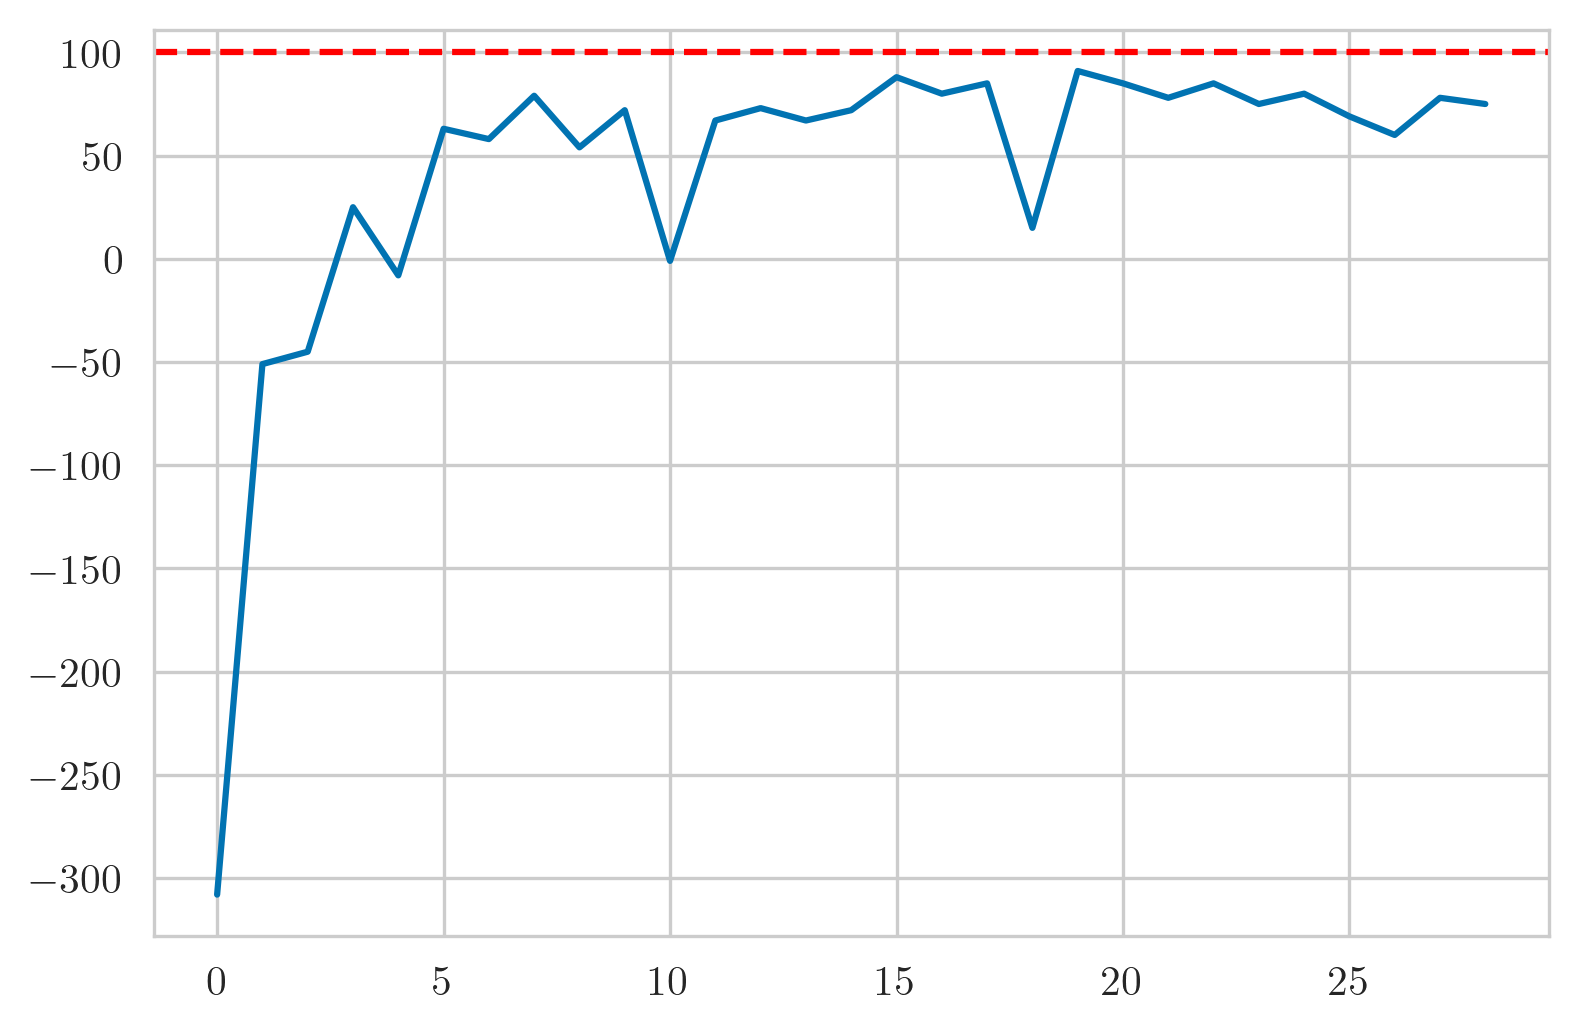

In [672]:
plt.plot([sum(dqn.rewards[(i * 100): ((i + 1) * 100)]) for i in range(29)])
plt.axhline(y=100, color='r', linestyle='--')

Double DQN даже при такой же архитектуре с этим небольшим хаком намного быстрее обучается и делает меньше ошибок 